<h2><center> Total variation deblurring </center></h2>

### In this demo, we solve the following minimisation problem:

$$\begin{equation}
\underset{u}{\operatorname{argmin}} \frac{1}{2} \| A u - g\|^{2}_{2} + \alpha\,\mathrm{TV}(u)
\end{equation}$$

where,

* g is a noisy data corrupted with Gaussian noise,
* $A$ is a Blurring operator,
* TV stands for the Total variation regulariser.

To solve the above problem, we use the **Fast Iterative Shrinkage-Thresholding Algorithm (FISTA)**
proposed in [BeckTeboulle](https://epubs.siam.org/doi/10.1137/080716542).

In [1]:
# Import libraries
from cil.optimisation.algorithms import FISTA
from cil.optimisation.operators import BlurringOperator
from cil.optimisation.functions import L2NormSquared, LeastSquares, TotalVariation
from cil.utilities import dataexample, noise
from cil.utilities.display import show2D
from cil.plugins.ccpi_regularisation.functions import FGP_TV

import numpy as np

We load an image from the `dataexample` class. In this demo, we use the `SHAPES` image. 

Other options are: 

* `BOAT`
* `CAMERA`
* `PEPPERS`(color)
* `RESOLUTION_CHART` 
* `SIMPLE_PHANTOM_2D` 
* `RAINBOW` (color)

In [2]:
# Load data
data = dataexample.SHAPES.get()

# Extract image geometry
ig = data.geometry

Next, we define a **Point Spread Function (PSF)** and the BlurringOperator. To obtain our blurred and noisy image, we create the blurred image using the BlurringOperator and Gaussian noise is added with relatively small variance.

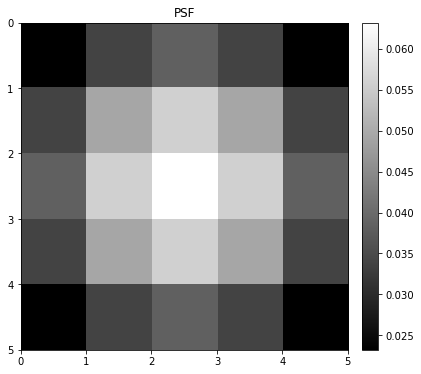

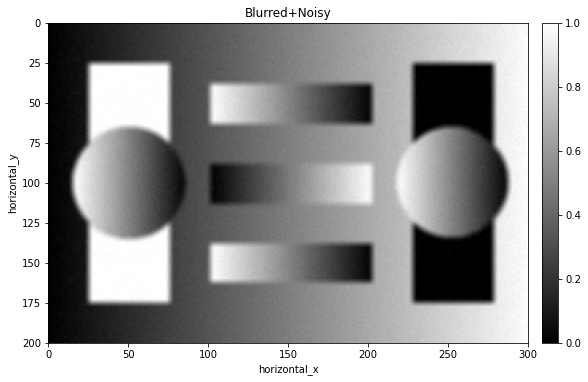

In [3]:
# Parameters for point spread function PSF (size and std)
ks          = 5; 
ksigma      = 2;

# Create 1D PSF and 2D as outer product, then normalise.
w           = np.exp(-np.arange(-(ks-1)/2,(ks-1)/2+1)**2/(2*ksigma**2))
w.shape     = (ks,1)
PSF         = w*np.transpose(w)
PSF         = PSF/(PSF**2).sum()
PSF         = PSF/PSF.sum()

# Display PSF as image
show2D(PSF, origin="upper", title="PSF", size=(10,10))

# Create blurring operator and apply to clean image to produce blurred and display.
BOP = BlurringOperator(PSF,ig)
blurred_noisy = noise.gaussian(BOP.direct(data), seed = 10, var = 0.0001)

# Show blurred and noisy image
show2D(blurred_noisy, origin="upper", title="Blurred+Noisy", size=(10,10))

Finally, we setup and run the FISTA algorithm using the Total variation regularisation. We can use either:

* **TotalVariation** from CIL as ```alpha * TotalVariation(max_iteration=10)``` or 
* **FGP_TV** from the CCPi-Regularisation toolkit as ```alpha * FGP_TV(max_iteration=10, device='cpu')```.

**Note:** Both functions implement the Fast Gradient Projection (FGP) algorithm inside their `proximal method`. In addition, the `FGP_TV` offers `cpu` and `gpu` acceleration options.

In [4]:
# Setup and run FISTA algorithm 
alpha = 0.05
G = alpha * FGP_TV(max_iteration=10, device='cpu')
F = LeastSquares(BOP, blurred_noisy)

fista = FISTA(initial = ig.allocate(0), f = F, g = G, 
              max_iteration = 200, update_objective_interval = 50)
fista.run()  

FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          2.03298e+04
       50        200         0.016          6.66496e+01
      100        200         0.013          6.66474e+01
      150        200         0.012          6.66475e+01
      200        200         0.012          6.66476e+01
-------------------------------------------------------
      200        200         0.012          6.66476e+01
Stop criterion has been reached.



In [ ]:
show2D([data, blurred_noisy, fista.solution], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Deblurred'], 
       origin="upper", num_cols=3)